In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
from functools import reduce
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# 분류모델 import 
# Logistic Regression,SGD,KNN,SVM,Decision Tree, Random Forest, LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,roc_auc_score,f1_score

lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
lgbm = LGBMClassifier()

In [5]:
df_coldwave = pd.read_csv('./preprocessed/df_coldwave.csv',encoding='cp949',index_col=0)
df_kr = pd.read_csv('./preprocessed/국내기후(백령도제외).csv',index_col=0)

In [6]:
df_coldwave.drop(['연도','날짜','지점'],axis=1,inplace=True)

In [7]:
# 중복된 날짜 제거 
df_coldwave = df_coldwave.drop_duplicates()

In [8]:
df_kr.rename(columns={'시간':'일시'},inplace=True)

In [9]:
# 주변국과 바다기후를  merge
cold_kr = pd.merge(df_coldwave,df_kr, how='right',on='일시')

In [10]:
# 재난일어난날 컬럼을 바이너리로 만들기 
cold_kr['재난일어난날'] = cold_kr['재난일어난날'].fillna(0)

In [11]:
cold_kr['재난일어난날'] =cold_kr['재난일어난날'].apply(lambda x: x if str(x) == '0' else '1')

In [12]:
# 전부 뉴메릭으로 만들기 
cold_kr['재난일어난날']=cold_kr['재난일어난날'].astype(int)

In [13]:
cold_kr.drop('일시',axis=1,inplace=True)

In [14]:
cold_kr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93504 entries, 0 to 93503
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   재난일어난날       93504 non-null  int32  
 1   관측지점         93504 non-null  object 
 2   평균 기온        93504 non-null  float64
 3   최저 기온        93504 non-null  float64
 4   최고 기온        93504 non-null  float64
 5   1시간 최다강수량    93504 non-null  float64
 6   일강수량         93504 non-null  float64
 7   최대 순간풍속      93504 non-null  float64
 8   최대 순간 풍속 풍향  93504 non-null  float64
 9   최대 풍속        93504 non-null  float64
 10  최대 풍속 풍향     93504 non-null  float64
 11  평균 풍속        93504 non-null  float64
 12  풍정합          93504 non-null  float64
 13  최대 풍향        93504 non-null  float64
 14  평균 이슬점온도     93504 non-null  float64
 15  평균 상대습도      93504 non-null  float64
 16  평균 증기압       93504 non-null  float64
 17  평균 현지기압      93504 non-null  float64
 18  최고 해면 기압     93504 non-null  float64
 19  최저 해

In [15]:
# 위치를 원핫인코딩하기
cold_kr = pd.get_dummies(cold_kr)

In [16]:
# 재난일어난날 2주뒤로 미뤄서 예측값 찾기 
cold_kr['재난일어난날'] = cold_kr['재난일어난날'].shift(periods=14, axis=0)

In [17]:
# 뒤로미룬만큼 생긴 nan값 제거 
cold_kr.dropna(inplace=True)

In [18]:
cold_kr

,재난일어난날,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,...,합계 소형증발량,안개 계속 시간,관측지점_강릉,관측지점_광주,관측지점_대구,관측지점_서울,관측지점_전주,관측지점_제주,관측지점_청주,관측지점_춘천
14,1.0,-3.3,-5.0,-1.9,0.0,0.0,8.0,320.0,5.0,320.0,...,1.0,0.0,0,0,0,1,0,0,0,0
15,1.0,-3.4,-7.9,1.4,0.0,0.0,6.9,270.0,5.0,270.0,...,1.1,0.0,0,0,0,1,0,0,0,0
16,1.0,0.9,-3.3,5.7,0.0,0.0,8.8,200.0,5.8,200.0,...,1.4,0.0,0,0,0,1,0,0,0,0
17,1.0,2.5,-4.1,5.2,0.0,3.0,12.1,290.0,7.0,290.0,...,1.6,0.0,0,0,0,1,0,0,0,0
18,0.0,-5.6,-9.3,-2.4,0.0,0.0,12.2,290.0,7.3,290.0,...,1.7,0.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93499,0.0,4.1,0.8,6.5,0.0,0.1,12.8,20.0,6.8,20.0,...,1.4,0.0,0,0,0,0,0,1,0,0
93500,0.0,7.2,5.9,8.4,0.0,0.0,9.1,360.0,5.3,340.0,...,1.3,0.0,0,0,0,0,0,1,0,0
93501,0.0,9.3,6.6,11.5,0.0,0.4,12.8,340.0,7.9,320.0,...,3.3,0.0,0,0,0,0,0,1,0,0
93502,0.0,6.9,5.8,8.4,0.0,0.0,18.1,340.0,10.1,340.0,...,3.2,0.0,0,0,0,0,0,1,0,0


In [19]:
y = cold_kr.재난일어난날
x = cold_kr.drop('재난일어난날',axis=1)

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [21]:
models = [lr,dtc,rfc,lgbm]
# result = []
for i in models:
    i.fit(x_train,y_train)
    pred = i.predict(x_test)
    proba = i.predict_proba(x_test)[:,1]
    
    print(i.__class__.__name__)
    print(classification_report(y_test,pred))
    print('roc_auc_score :',roc_auc_score(y_test,proba))
    print('-'*50)

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.93     16544
         1.0       0.46      0.23      0.31      2154

    accuracy                           0.88     18698
   macro avg       0.68      0.60      0.62     18698
weighted avg       0.85      0.88      0.86     18698

roc_auc_score : 0.8983593902936194
--------------------------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     16544
         1.0       0.40      0.44      0.42      2154

    accuracy                           0.86     18698
   macro avg       0.66      0.68      0.67     18698
weighted avg       0.87      0.86      0.86     18698

roc_auc_score : 0.6753722438933278
--------------------------------------------------
RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     16544


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [23]:
scaler.fit(x_train)

StandardScaler()

In [24]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [25]:
y_train.value_counts()

0.0    65944
1.0     8848
Name: 재난일어난날, dtype: int64

In [26]:
import imblearn
from imblearn.over_sampling import SMOTE

In [27]:
smote = SMOTE(random_state=0)
x_train_sm,y_train_sm = smote.fit_resample(x_train_scaled,y_train)

In [28]:
y_train_sm.value_counts()

0.0    65944
1.0    65944
Name: 재난일어난날, dtype: int64

In [ ]:
models = [lr,dtc,rfc,lgbm]
# result = []
for i in models:
    i.fit(x_train_sm,y_train_sm)
    pred = i.predict(x_test_scaled)
    proba = i.predict_proba(x_test_scaled)[:,1]
    
    print(i.__class__.__name__)
    print(classification_report(y_test,pred))
    print('roc_auc_score :',roc_auc_score(y_test,proba))
    print('-'*50)
    

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88     16544
         1.0       0.37      0.93      0.53      2154

    accuracy                           0.81     18698
   macro avg       0.68      0.86      0.70     18698
weighted avg       0.92      0.81      0.84     18698

roc_auc_score : 0.9144504387949907
--------------------------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91     16544
         1.0       0.38      0.51      0.44      2154

    accuracy                           0.85     18698
   macro avg       0.66      0.70      0.68     18698
weighted avg       0.87      0.85      0.86     18698

roc_auc_score : 0.702612930331586
--------------------------------------------------
RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     16544
 

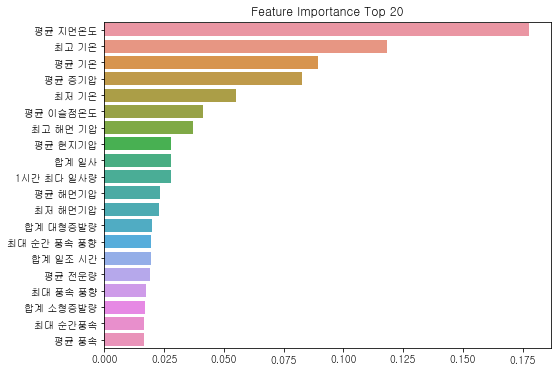

--------------------------------------------------


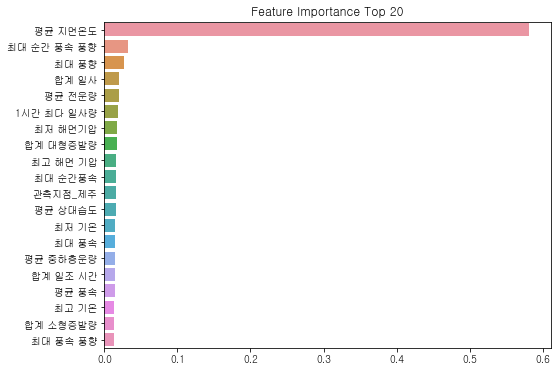

--------------------------------------------------


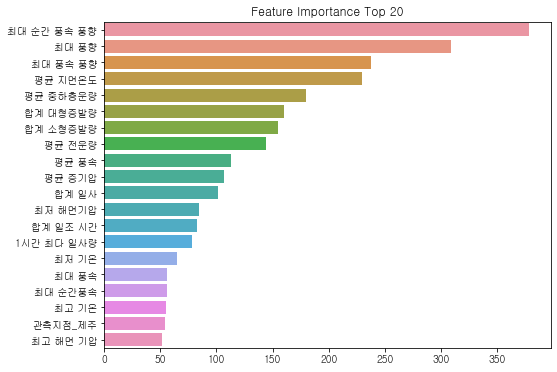

--------------------------------------------------


In [40]:
# from xgboost import XGBClassifier

# # model = XGBClassifier(random_state=11)
# # model.fit(X_train, y_train)

# # 배열형태로 반환
# ft_importance_values = lgbm.feature_importances_

# # 정렬과 시각화를 쉽게 하기 위해 series 전환
# ft_series = pd.Series(ft_importance_values, index = x_train.columns)
# ft_top20 = ft_series.sort_values(ascending=False)[:20]

# # 시각화
# plt.figure(figsize=(8,6))
# plt.title('Feature Importance Top 20')
# sns.barplot(x=ft_top20, y=ft_top20.index)
# plt.show()
model =[rfc, dtc, lgbm]
for i in model:
    # 배열형태로 반환
    ft_importance_values = i.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
    ft_series = pd.Series(ft_importance_values, index = x_train.columns)
    ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
    plt.figure(figsize=(8,6))
    plt.title('Feature Importance Top 20')
    sns.barplot(x=ft_top20, y=ft_top20.index)
    plt.show()
    print('-'*50)

In [39]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)